In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-12 21:04:10.006135: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-12 21:04:10.006231: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-12 21:04:10.006241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "funnel")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.075
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.sigma = 1.075
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
config.trainer.learning_rate = 5 * 10**(-3)
config.trainer.lr_sch_base_dec = 0.95 # For funnel
config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 1000
config.trainer.learning_rate = 5 * 10**(-3)

In [3]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [4]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f2323937490>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f2323937640>)


In [5]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [6]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 5.540777683258057)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 5.2238264083862305)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 5.046825885772705)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 5.374197006225586)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 6.4048871994018555)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 6.665024757385254)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 6.923305511474609)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 5.894010066986084)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 5.234142780303955)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 4.991605281829834)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 4.972844123840332)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 5.225154876708984)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 5.726051330566406)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 5.824143409729004)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 6.552172660827637)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 6.928567409515381)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 7.321991443634033)
('epo

('epoch: %s %s  loss: %s', 138, 'TRAIN', 4.598417282104492)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 4.478027820587158)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 4.633368492126465)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 4.61287260055542)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 4.81246280670166)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 4.681672096252441)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 4.7885003089904785)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 4.650444030761719)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 4.617028713226318)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 4.559966087341309)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 4.5419745445251465)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 4.390381813049316)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 4.3983869552612305)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 4.375454425811768)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 4.199345111846924)
('epoch: %s %s  loss: %s', 153, 'TRAIN', 4.254202842712402)
('epoch: %s %s  loss: %s', 154, 'TRAIN'

('epoch: %s %s  loss: %s', 275, 'TRAIN', 4.7365217208862305)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 4.612115383148193)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 4.600709438323975)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 4.839572906494141)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 4.63194465637207)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 4.802245140075684)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 4.656616687774658)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 4.76728630065918)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 4.651515960693359)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 4.590925693511963)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 4.809148788452148)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 4.963508129119873)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 4.457091331481934)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 4.550848007202148)
('epoch: %s %s  loss: %s', 289, 'TRAIN', 4.490318298339844)
('epoch: %s %s  loss: %s', 290, 'TRAIN', 4.377750396728516)
('epoch: %s %s  loss: %s', 291, 'TRAIN', 

('epoch: %s %s  loss: %s', 412, 'TRAIN', 5.3751349449157715)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 5.372859477996826)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 5.240752220153809)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 5.269681453704834)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 5.350736618041992)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 5.324925899505615)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 5.13322114944458)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 4.988095760345459)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 4.951550483703613)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 5.233394622802734)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 4.902585983276367)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 4.758442401885986)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 4.739513874053955)
('epoch: %s %s  loss: %s', 425, 'TRAIN', 4.518385887145996)
('epoch: %s %s  loss: %s', 426, 'TRAIN', 4.504847049713135)
('epoch: %s %s  loss: %s', 427, 'TRAIN', 4.584296226501465)
('epoch: %s %s  loss: %s', 428, 'TRAIN',

('epoch: %s %s  loss: %s', 549, 'TRAIN', 5.3668389320373535)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 4.931700229644775)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 4.669372081756592)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 4.746779918670654)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 4.6665940284729)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 4.5551838874816895)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 4.5562872886657715)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 4.536380290985107)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 4.469204425811768)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 4.460672855377197)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 4.468067169189453)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 4.464089870452881)
('epoch: %s %s  loss: %s', 561, 'TRAIN', 4.403601169586182)
('epoch: %s %s  loss: %s', 562, 'TRAIN', 4.411989212036133)
('epoch: %s %s  loss: %s', 563, 'TRAIN', 4.621656894683838)
('epoch: %s %s  loss: %s', 564, 'TRAIN', 4.787629127502441)
('epoch: %s %s  loss: %s', 565, 'TRAIN'

('epoch: %s %s  loss: %s', 686, 'TRAIN', 4.827428817749023)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 4.539355754852295)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 4.602056980133057)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 4.547597885131836)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 4.269555568695068)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 4.3314104080200195)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 4.397832870483398)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 4.471160888671875)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 4.976417064666748)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 5.043962001800537)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 5.3990373611450195)
('epoch: %s %s  loss: %s', 697, 'TRAIN', 5.148033618927002)
('epoch: %s %s  loss: %s', 698, 'TRAIN', 5.280594348907471)
('epoch: %s %s  loss: %s', 699, 'TRAIN', 5.260217189788818)
('epoch: %s %s  loss: %s', 700, 'TRAIN', 5.149506568908691)
('epoch: %s %s  loss: %s', 701, 'TRAIN', 4.934388160705566)
('epoch: %s %s  loss: %s', 702, 'TRAIN

('epoch: %s %s  loss: %s', 823, 'TRAIN', 4.875580310821533)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 4.868044853210449)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 4.939945697784424)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 4.812597751617432)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 5.230742454528809)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 5.035634517669678)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 4.981735706329346)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 5.150680065155029)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 5.024435997009277)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 5.105493545532227)
('epoch: %s %s  loss: %s', 833, 'TRAIN', 5.01832914352417)
('epoch: %s %s  loss: %s', 834, 'TRAIN', 4.842254161834717)
('epoch: %s %s  loss: %s', 835, 'TRAIN', 4.859200477600098)
('epoch: %s %s  loss: %s', 836, 'TRAIN', 4.790403366088867)
('epoch: %s %s  loss: %s', 837, 'TRAIN', 4.623154640197754)
('epoch: %s %s  loss: %s', 838, 'TRAIN', 4.764171600341797)
('epoch: %s %s  loss: %s', 839, 'TRAIN', 

('epoch: %s %s  loss: %s', 960, 'TRAIN', 4.743497371673584)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 4.779280662536621)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 4.641628265380859)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 4.686359882354736)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 4.700382232666016)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 4.629299163818359)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 4.614994525909424)
('epoch: %s %s  loss: %s', 967, 'TRAIN', 4.713974475860596)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 4.554605960845947)
('epoch: %s %s  loss: %s', 969, 'TRAIN', 4.348572254180908)
('epoch: %s %s  loss: %s', 970, 'TRAIN', 4.184980869293213)
('epoch: %s %s  loss: %s', 971, 'TRAIN', 4.075021743774414)
('epoch: %s %s  loss: %s', 972, 'TRAIN', 3.9642035961151123)
('epoch: %s %s  loss: %s', 973, 'TRAIN', 4.009428977966309)
('epoch: %s %s  loss: %s', 974, 'TRAIN', 3.9636244773864746)
('epoch: %s %s  loss: %s', 975, 'TRAIN', 3.891305923461914)
('epoch: %s %s  loss: %s', 976, 'TRAIN

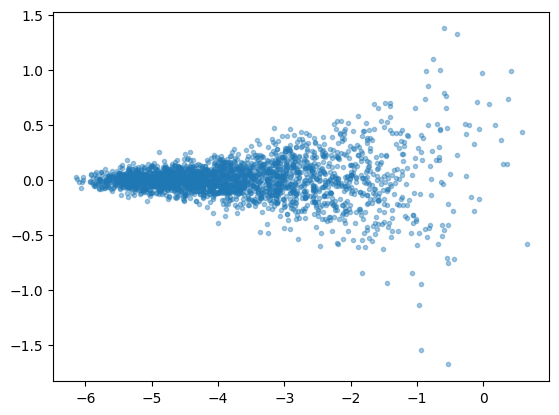

In [9]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

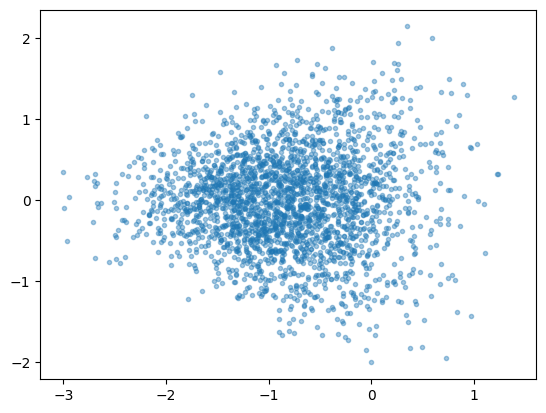

In [8]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [13]:
jnp.array(results_dict["is"]).mean()

DeviceArray(0.66988075, dtype=float32)

In [14]:
results_dict["is"]

[0.7180566787719727,
 0.5765042304992676,
 0.3730349540710449,
 1.301534652709961,
 1.6028928756713867,
 1.0354843139648438,
 1.4281635284423828,
 0.33297014236450195,
 0.7756710052490234,
 0.8802027702331543,
 1.2416043281555176,
 0.8268976211547852,
 -1.2096977233886719,
 1.4628629684448242,
 0.18280696868896484,
 0.49139404296875,
 0.630516529083252,
 -0.4393806457519531,
 0.7954306602478027,
 1.2436027526855469,
 0.5174612998962402,
 0.7461323738098145,
 1.0178618431091309,
 1.1474485397338867,
 0.16848468780517578,
 1.2337956428527832,
 0.4978761672973633,
 1.108637809753418,
 1.1983370780944824,
 -0.4638328552246094,
 1.1085786819458008,
 0.2752971649169922,
 0.6197686195373535,
 1.1576385498046875,
 1.0227031707763672,
 0.09201574325561523,
 0.73980712890625,
 1.1362967491149902,
 0.7653532028198242,
 0.7508754730224609,
 0.9520339965820312,
 0.6412110328674316,
 0.4524068832397461,
 0.8173775672912598,
 1.0849571228027344,
 0.8182144165039062,
 1.0763306617736816,
 1.1474351882